# This code is used to perform the exploratory analysis of our dataset, in order to obtain the complexity and determine certain distribution factors.

## Import the library

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from sklearn.linear_model import LinearRegression

## Import the dataset

In [77]:
# import the data
data = pd.read_csv('Comerciantes_Bazurto.csv')
df = pd.DataFrame(data)

# print the first 2 rows of the data
# print(df.head(2))

# get the descriptive statistics of the data
print(df.describe())

            _index  ¿Cuántos años cumplidos tiene?  \
count  3042.000000                     3042.000000   
mean   1953.321170                       48.400723   
std     993.557782                       16.362513   
min       1.000000                        0.000000   
25%    1158.250000                       38.000000   
50%    2020.500000                       50.000000   
75%    2801.750000                       58.000000   
max    3583.000000                      544.000000   

       ¿Es Ud. Victima del Conflicto o Persona en Situación de Discapacidad?/Víctima del conflicto armado  \
count                                        3042.000000                                                    
mean                                            0.092373                                                    
std                                             0.289600                                                    
min                                             0.000000                     

### calculate data completeness before data cleaning

In [78]:
# Calculate completeness and missing values with optimized expressions
total_values = df.size  # Total elements
missing_values = df.isnull().sum().sum()  # Total missing elements
completeness_total = 100 * (1 - missing_values / total_values)  # Overall completeness in percentage
completeness_columns = df.notnull().mean() * 100  # Completeness per column in percentage

# Display the overall completeness in the dataset
print(f"Total values: {total_values:.2f}")
print(f"Missing values: {missing_values:.2f}")
print(f"Dataset completeness: {completeness_total:.2f}%")

# Display column completeness
print("\nCompleteness by column:")
print(completeness_columns.head(10))

# Duplicate check
print(f"Duplicate rows in data: {df.duplicated().sum()}")

Total values: 690534.00
Missing values: 310323.00
Dataset completeness: 55.06%

Completeness by column:
_index                                                                                                        100.000000
fecha                                                                                                         100.000000
Código del sector que le fue asignado del Mercado                                                             100.000000
Observe con cuidado a la persona que va a encuestar y elija el mejor descriptor posible.                      100.000000
¿El comercio está abierto?                                                                                     76.068376
¿Cuántos años cumplidos tiene?                                                                                100.000000
Cuál es su género?                                                                                            100.000000
¿Ud. Se autoreconoce en algunos de los siguientes

## Preparation of the data to be analyzed

In [79]:
# Load JSON data once for product/service columns
with open('productos.json', 'r', encoding='utf-8') as file:
    data_json = json.load(file)
columnas_productos = data_json['columnas_productos']


def extract_category(name):
    match = re.search(r'/([^/]+?)(?:\s*\(|$)', name)
    return match.group(1).strip() if match else name

# Pre-compute category names
category_map = {col: extract_category(col) for col in columnas_productos}

# Use numpy select for faster conditional column creation
product_columns = df[columnas_productos]
df['Tipo de producto/servicio'] = np.select(
    [product_columns[col] == 1 for col in columnas_productos],
    [category_map[col] for col in columnas_productos],
    default='Otro'
)

In [80]:
# Columns related to EPS affiliation
columnas_eps = [
    "¿Está afiliado(a) a alguna entidad de seguridad social en salud (EPS) ?",
    "¿A cuál de los siguientes regímenes de seguridad social en salud está afiliado?:",
    "¿Alguna vez ha estado afiliado(a), como cotizante o beneficiario(a), a alguna entidad de seguridad social en salud?"
]

# Function to determine membership status
def combinar_eps(row):
    """
    Function to determine the affiliation status of a person to the EPS
    :param row: row of the dataframe
    :return: affiliation status
    """
    # Check if all columns are 'NO', empty, or 'NS/NR'
    if all(row[col] in ['NO', '', 'NS/NR', None] or not isinstance(row[col], str) for col in columnas_eps):
        return 'No afiliado'
    
    for col in columnas_eps:
        # Ensure that the value is a string and is not empty
        if isinstance(row[col], str) and row[col].startswith('SI'):
            # Return the type of affiliation according to the scheme
            if isinstance(row[columnas_eps[1]], str):  # Check if the second column is not empty
                if 'Subsidiado' in row[columnas_eps[1]]:
                    return 'Subsidiado'
                elif 'Contributivo' in row[columnas_eps[1]]:
                    return 'Contributivo'
            return row[columnas_eps[1]]

    return 'Sin datos'  # In case of not having a clear answer

# Create a new column with the affiliation
df['Afiliación a EPS'] = df.apply(combinar_eps, axis=1)


In [81]:
# Transport columns
transporte = [
    "¿Qué medio de transporte utiliza principalmente para desplazarse a su sitio de trabajo/Mercado?",
    "Otro medio de transporte. ¿Cuál?"
]

# Function to combine columns
def combinar_transporte(row):
    """
    Function to combine the transport columns
    :param row: row of the dataframe
    :return: the combined transport
    """
    if row[transporte[0]] == 'Otro.':
        return row[transporte[1]]
    return row[transporte[0]]

# Create a new column with the combined transport
df['Medio de transporte'] = df.apply(combinar_transporte, axis=1)


In [82]:
# Columns related to the level of education
columnas_escolaridad = [
    "¿Tiene diploma de alguno de los siguientes niveles de escolaridad?",
    "¿Hasta que curso logró completar?"
]


def agrupar_escolaridad(row):
    """
    Function to group the level of education into categories.
    :param row: row of the dataframe
    :return: level of education
    """

    if (pd.isnull(row[columnas_escolaridad[0]]) or row[columnas_escolaridad[0]] == 'NS/NR') and \
       (pd.isnull(row[columnas_escolaridad[1]]) or row[columnas_escolaridad[1]] == 'NS/NR'):
        return 'NS/NR'

    # If you don't have a diploma, group by course
    if row[columnas_escolaridad[0]] == 'Ninguno':
        curso = str(row[columnas_escolaridad[1]])

        if curso == 'NS/NR':
            return 'NS/NR'
        elif '1°' <= curso <= '4°':
            return 'Primaria incompleta'
        elif curso == '5°' or curso == 'Básica primaria (1.°-5.°)':
            return 'Primaria completa'
        elif '6°' <= curso <= '9°' or curso == 'Basíca secundaria (6.° - 9.°)':
            return 'Básica completa'
        elif curso == 'Media (10.° - 13.°)':
            return 'Media completa'
        else:
            return 'Bachillerato completo'

    # If you have a diploma, group by level
    if row[columnas_escolaridad[0]] == "Bachiller":
        return 'Bachillerato completo'
    
    elif row[columnas_escolaridad[0]] == "Técnico o tecnólogo":
        return 'Técnico'
    
    elif row[columnas_escolaridad[0]] == "Universitario":
        return 'Profesional'
    
    elif row[columnas_escolaridad[0]] == "Postgrado":
        return 'Postgrado'
    

    # If you have a diploma, return the level of education
    return row[columnas_escolaridad[0]]


# create a new column with the level of education
df['Nivel de escolaridad'] = df.apply(agrupar_escolaridad, axis=1)

In [83]:
# Social security columns

columnas_seguridad_social = [
    "¿Está cotizando en alguna entidad de seguridad social en pensiones?",
    "¿Está afiliado(a) a alguna entidad de seguridad social en riesgos laborales (ARL)?",
]


def validar_seguridad_social(row):
    """
    Function to determine the affiliation status of a person to the social security
    :param row: row of the dataframe
    :return: affiliation status
    """
    if not row[columnas_seguridad_social[0]] and not row[columnas_seguridad_social[1]]:
        return 'No afiliado'
    else:
        return 'Afiliado'

# Create a new column with the affiliation
df['seguridad social sin salud'] = df.apply(validar_seguridad_social, axis=1)

In [84]:
# Columns related to the management of waste

columnas_basuras = [
    "¿Qué hace con la basura que produce en el desarrollo de su actividad económica/local?",
    "Otro. ¿Cuál?...416"
]

def validar_basuras(row):
    if row[columnas_basuras[0]] == 'Otro. ¿Cuál?':
        return row[columnas_basuras[1]]
    return row[columnas_basuras[0]]

df['Manejo de basuras'] = df.apply(validar_basuras, axis=1)

In [85]:
# Worker management columns
worker_colums = [
    "¿Cuántos trabajadores extranjeros tiene?"
]

def validar_trabajadores(row):
    """
    function to validate the number of foreign workers
    :param row: row of the dataframe
    :return: the number of foreign workers
    """
    if row[worker_colums[0]] == 'NS/NR':
        return 0
    
    return row[worker_colums[0]]

# create a new column with the number of foreign workers
df['¿Cuántos trabajadores extranjeros tiene?'] = df.apply(validar_trabajadores, axis=1)

# Ruv management 
columnas_ruv = [
    "¿Está inscrito en el Registro Único de Víctimas - RUV?"
]

def validar_ruv(row):
    """
    Function to validate the affiliation to the RUV (Registro Único de Víctimas)
    :param row: row of the dataframe
    :return: the affiliation to the RUV
    """
    if row[columnas_ruv[0]] == 'NS/NR':
        return 'NO'
    
    
    return row[columnas_ruv[0]]

# create a new column with the affiliation to the RUV
df['¿Está inscrito en el Registro Único de Víctimas - RUV?'] = df.apply(validar_ruv, axis=1)

# Disability columns
columnas_discapacidad = [
    "¿Qué tipo(s) de discapacidad tiene?"
]

def validar_discapacidad(row):
    if row[columnas_discapacidad[0]] == 'NS/NR':
        return 'Sin discapacidad'
    
    return row[columnas_discapacidad[0]]

df['¿Qué tipo(s) de discapacidad tiene?'] = df.apply(validar_discapacidad, axis=1)


# Contract columns
columnas_contratos = [
    "En su mayoría, ¿qué tipo de contrato tienen sus trabajadores?",
    "En su mayoría, ¿los contratos de trabajo son a término indefinido o a término fijo?"
]

def validar_contratos(row):
    """
    Function to validate the type of contract
    :param row: row of the dataframe
    :return: the type of contract
    """
    if row[columnas_contratos[0]] == 'No sabe, no informa':
        return 'NS/NR'
    
    return row[columnas_contratos[0]]

def validar_tipos_de_contratos(row):
    if row[columnas_contratos[1]] == 'NS/NR':
        return 'Sin información'

# create a new column with the type of contract
df['En su mayoría, ¿qué tipo de contrato tienen sus trabajadores?'] = df.apply(validar_contratos, axis=1)
df['En su mayoría, ¿los contratos de trabajo son a término indefinido o a término fijo?'] = df.apply(validar_tipos_de_contratos, axis=1)

In [86]:
# Define the columns related to the Chamber of Commerce
chamber_commerce = [
    "¿Tiene registro ante la Cámara de Comercio?",
    "¿Su registro ante la Cámara de Comercio está actualizado a 2021?"
]

# Define conditions for creating the camera registration status 
conditions = [
    (df[chamber_commerce[0]].isnull() & (df[chamber_commerce[1]] == "SI")),  # Registration updated even if the first one is in NaN 
    (df[chamber_commerce[0]].isnull() | (df[chamber_commerce[0]] == False)),  # No record
    (df[chamber_commerce[0]] == "SI") & (df[chamber_commerce[1]] == "NO"),    # Has registration but not updated
    (df[chamber_commerce[0]] == "SI") & (df[chamber_commerce[1]] == "SI")     # Registered and up to date
]

# Values we want to assign for each condition
values = [
    "Tiene registro y está actualizado",     # Case when record is in NaN but the other field is “YES”.
    "No tiene registro",                     # No record
    "Tiene registro pero no está actualizado",  # Has registration but not updated
    "Tiene registro y está actualizado"      # Registered and up to date
]

# Create the new column based on the conditions
df["Estado de Registro Cámara"] = np.select(conditions, values, default="Estado desconocido")


In [87]:
# Replace NaN values in '¿Cuántos trabajadores extranjeros tiene?' with 0
df['¿Cuántos trabajadores extranjeros tiene?'] = df['¿Cuántos trabajadores extranjeros tiene?'].fillna(0)

# Replace NaN values in 'Tipo de discapacidad with Sin discapacidad
df['¿Qué tipo(s) de discapacidad tiene?'] = df['¿Qué tipo(s) de discapacidad tiene?'].fillna('Sin discapacidad')

# Replace NaN values in '¿Cuenta con sisben? with NS/NR
df['¿Cuenta con SISBEN?'] = df['¿Cuenta con SISBEN?'].fillna('NS/NR')

In [88]:
# Define the columns related to the type of contract
contracts_column = [
    "En su mayoría, ¿qué tipo de contrato tienen sus trabajadores?",
    "En su mayoría, ¿los contratos de trabajo son a término indefinido o a término fijo?"
]

# Crear la nueva columna combinando las dos existentes
df["Tipo de contrato"] = df.apply(
    lambda row: f"{row[contracts_column[0]]}, {row[contracts_column[1]]}" if pd.notna(row[contracts_column[0]]) and pd.notna(row[contracts_column[1]]) 
                else row[contracts_column[0]] if pd.notna(row[contracts_column[0]]) 
                else row[contracts_column[1]] if pd.notna(row[contracts_column[1]]) 
                else "NS/NR",
    axis=1
)


In [89]:
# change names of columns

names = {
    "¿Es Ud. Victima del Conflicto o Persona en Situación de Discapacidad?/Persona en situación de discapacidad": "Discapacidad",
    "¿Es Ud. Victima del Conflicto o Persona en Situación de Discapacidad?/Víctima del conflicto armado": "Víctima del conflicto",
    "¿Ud. Se autoreconoce en algunos de los siguientes grupos etnicos?": "Grupo étnico",
    "¿Está inscrito en el Registro Único de Víctimas - RUV?": "RUV",
    "¿Qué tipo(s) de discapacidad tiene?": "Tipo de discapacidad",
    "¿Cuántos años cumplidos tiene?": "Edad",
    "Cuál es su género?": "Genero",
    "En un día promedio, ¿cuánto invierte en mercancía?...": "Inversión en mercancía",
    "Normalmente, ¿a qué hora recibe la mercancía?": "Hora de recepción de mercancía",
}

df.rename(columns=names, inplace=True)

with open('delete.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

delete = data['delete']
df.drop(columns=columnas_productos  +
        delete + columnas_eps + transporte + columnas_escolaridad + columnas_basuras + chamber_commerce + contracts_column , inplace=True)

# Create a dictionary with the columns of the dataframe
column_dict = {i: col for i, col in enumerate(df.columns)}

# Save the columns in a json file
with open('columnas.json', 'w', encoding='utf-8') as json_file:
    json.dump(column_dict, json_file, ensure_ascii=False, indent=4)

## calculate data completeness after data cleaning

In [90]:
total_values_adjusting = df.size  # Total values after adjustment the dataset


# Calculate completeness and missing values when adjusting the dataset
missing_values_adjusting = df.isnull().sum().sum()  # Total missing elements
# Overall completeness in percentage
completeness_total_adjusting = 100 * (1 - missing_values_adjusting / total_values_adjusting)
# Completeness per column in percentage
completeness_columns_adjusting = df.notnull().mean() * 100

# Display the overall completeness in the dataset
print(f"Total values before adjustment: {total_values:.2f}")
print(f"Total values after adjustment: {total_values_adjusting:.2f}")
print(f"Missing values before adjustment: {missing_values:.2f}")
print(f"Missing values after adjustment: {missing_values_adjusting:.2f}")
print(f"Dataset completeness before adjustment: {completeness_total:.2f}%")
print(f"Dataset completeness after adjustment: {completeness_total_adjusting:.2f}%")
print(f"percentage of missing values before adjustment: {100 * (1 - (completeness_total/100)):.2f} %")
print(f"percentage of missing values after adjustment: {100 * (1 - (completeness_total_adjusting/100)):.2f} %")


# Display column completeness
# print("completeness by column before adjustment:")
# print(completeness_columns.head(10))
# print("\nCompleteness by column adjustment:")
# print(completeness_columns_adjusting.head(10))

Total values before adjustment: 690534.00
Total values after adjustment: 69966.00
Missing values before adjustment: 310323.00
Missing values after adjustment: 992.00
Dataset completeness before adjustment: 55.06%
Dataset completeness after adjustment: 98.58%
percentage of missing values before adjustment: 44.94 %
percentage of missing values after adjustment: 1.42 %


## Identification of outliers

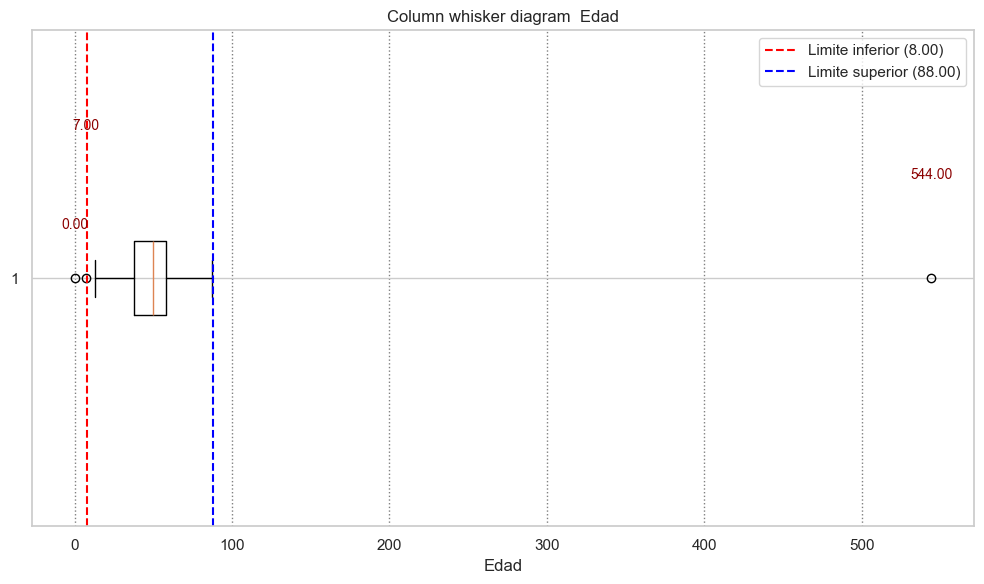

In [91]:
# Define the quantifiable column for age
column = "Edad" 

# Calculate Q1, Q3, and IQR
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)][column]

# Create boxplot for the age column
plt.figure(figsize=(10, 6))
plt.boxplot(df[column].dropna(), vert=False)
plt.title(f"Column whisker diagram  {column}")
plt.xlabel(column)

# Show limits and annotate outliers
plt.axvline(lower_limit, color='red', linestyle='--', label=f"Limite inferior ({lower_limit:.2f})")
plt.axvline(upper_limit, color='blue', linestyle='--', label=f"Limite superior ({upper_limit:.2f})")

# Display gridlines for better readability
plt.grid(axis='x', linestyle=':', color='gray')

# Annotate each outlier with its value, offset for clarity
for j, outlier in enumerate(outliers):
    plt.text(outlier, 1.1 + (j * 0.1), f"{outlier:.2f}", color="darkred", ha='center', fontsize=10)

# Add legend for limits
plt.legend()

plt.tight_layout()
plt.show()


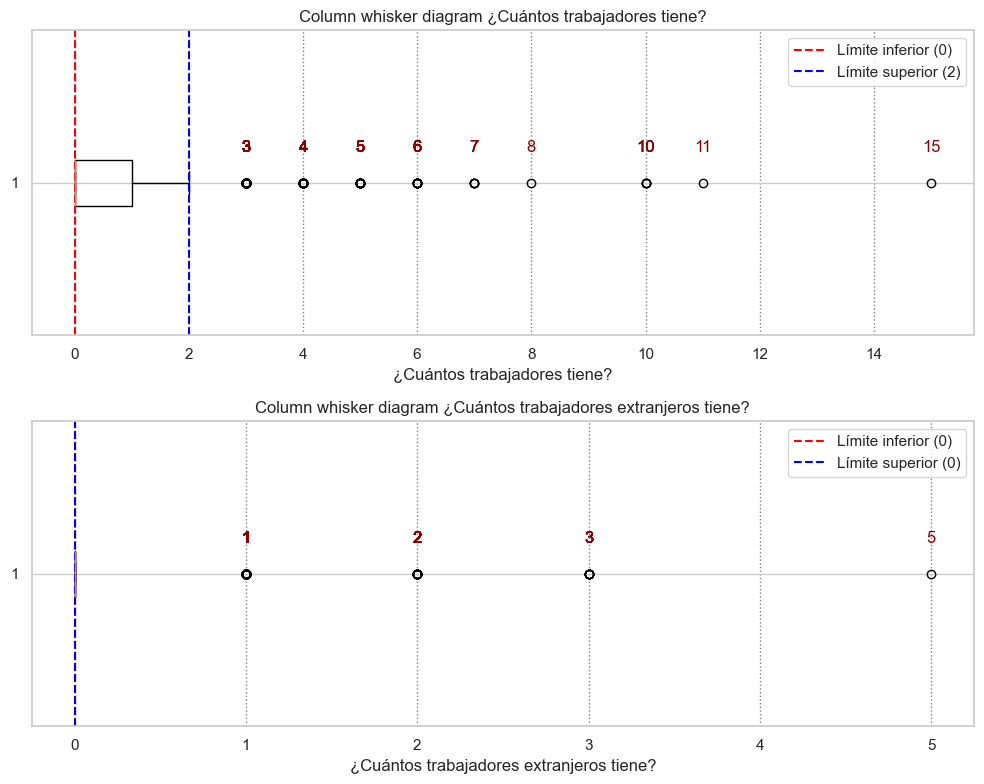

In [92]:
# Assuming df is already loaded with your data
# Define quantifiable columns
quantifiable_columns = [
    "¿Cuántos trabajadores tiene?",
    "¿Cuántos trabajadores extranjeros tiene?",
]

# Filter the DataFrame to include only quantifiable columns
df_quantitative = df[quantifiable_columns]

# Create a figure with individual subplots for each column
fig, axes = plt.subplots(nrows=len(quantifiable_columns), ncols=1, figsize=(10, len(quantifiable_columns) * 4))

# Generate a boxplot for each column
for i, column in enumerate(quantifiable_columns):
    # Calculate Q1, Q3, and IQR
    Q1 = df_quantitative[column].quantile(0.25)
    Q3 = df_quantitative[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = max(0, round(Q1 - 1.5 * IQR))  # Set lower limit to at least 0
    upper_limit = round(Q3 + 1.5 * IQR)
    
    # Identify outliers
    outliers = df_quantitative[(df_quantitative[column] < lower_limit) | 
                               (df_quantitative[column] > upper_limit)][column]
    
    # Create boxplot for the current column
    axes[i].boxplot(df_quantitative[column].dropna(), vert=False)
    axes[i].set_title(f"Column whisker diagram {column}")
    axes[i].set_xlabel(column)
    
    # Show limits and annotate outliers
    axes[i].axvline(lower_limit, color='red', linestyle='--', label=f"Límite inferior ({lower_limit})")
    axes[i].axvline(upper_limit, color='blue', linestyle='--', label=f"Límite superior ({upper_limit})")
    
    # Display gridlines for better readability
    axes[i].grid(axis='x', linestyle=':', color='gray')
    
    # Annotate each outlier with its integer value
    for outlier in outliers:
        axes[i].text(round(outlier), 1.1, f"{int(outlier)}", color="darkred", ha='center')
    
    # Add legend for limits
    axes[i].legend()

    # Set x-axis to display only integer values
    axes[i].xaxis.get_major_locator().set_params(integer=True)

plt.tight_layout()
plt.show()


## Adjustment of atypical data

In [93]:
column = "Edad" 

# Calculate Q1, Q3, and IQR
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
print(Q1, Q3, IQR, lower_limit, upper_limit)
# calculate the average of the values ​​that are within the limits
mean_without_outliers = df[(df["Edad"] >= lower_limit) & (df["Edad"] <= upper_limit)]["Edad"].mean()

# Replace outliers with the calculated mean
df["Edad"] = df["Edad"].apply(lambda x: mean_without_outliers if x < lower_limit or x > upper_limit else x)

# Check the result
print(df["Edad"].describe())

38.0 58.0 20.0 8.0 88.0
count    3042.000000
mean       48.267193
std        13.623913
min        13.000000
25%        38.000000
50%        50.000000
75%        58.000000
max        87.000000
Name: Edad, dtype: float64


## Creating graphs

### Correlation heat map

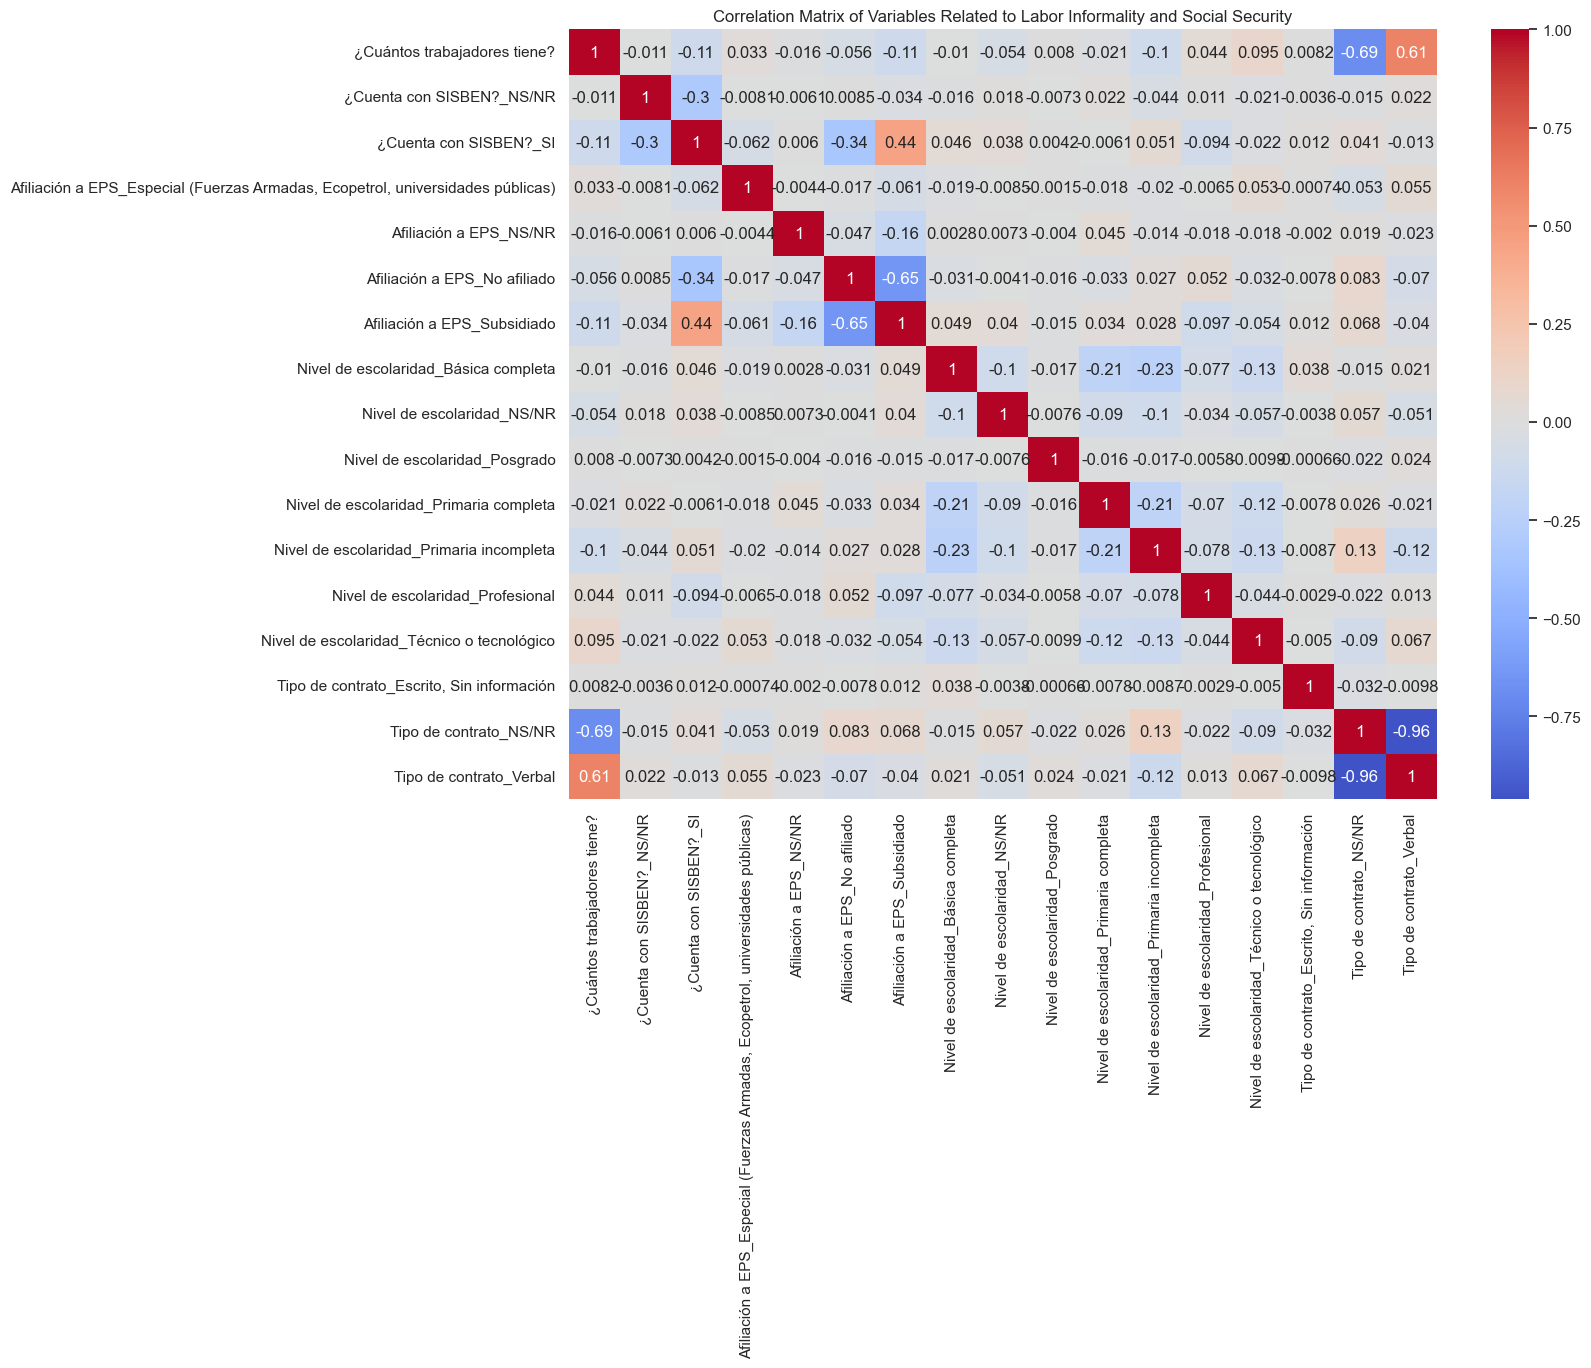

In [94]:
# List of columns relevant to the analysis
relevant_columns = [
    "¿Cuenta con SISBEN?", "¿Cuántos trabajadores tiene?",
    "Afiliación a EPS", "Nivel de escolaridad", "Tipo de contrato"
]

# Filter the DataFrame to include only relevant columns
filtered_df = df[relevant_columns]


encoded_df = pd.get_dummies(df[relevant_columns], drop_first=True)
# Calculate the correlation matrix
correlation_matrix = encoded_df.corr()
# Plot the correlation matrix

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Variables Related to Labor Informality and Social Security")
plt.show()

### Pareto 

Text(0.5, 1.0, 'Pareto diagram of the means of travel to the bazurto market.')

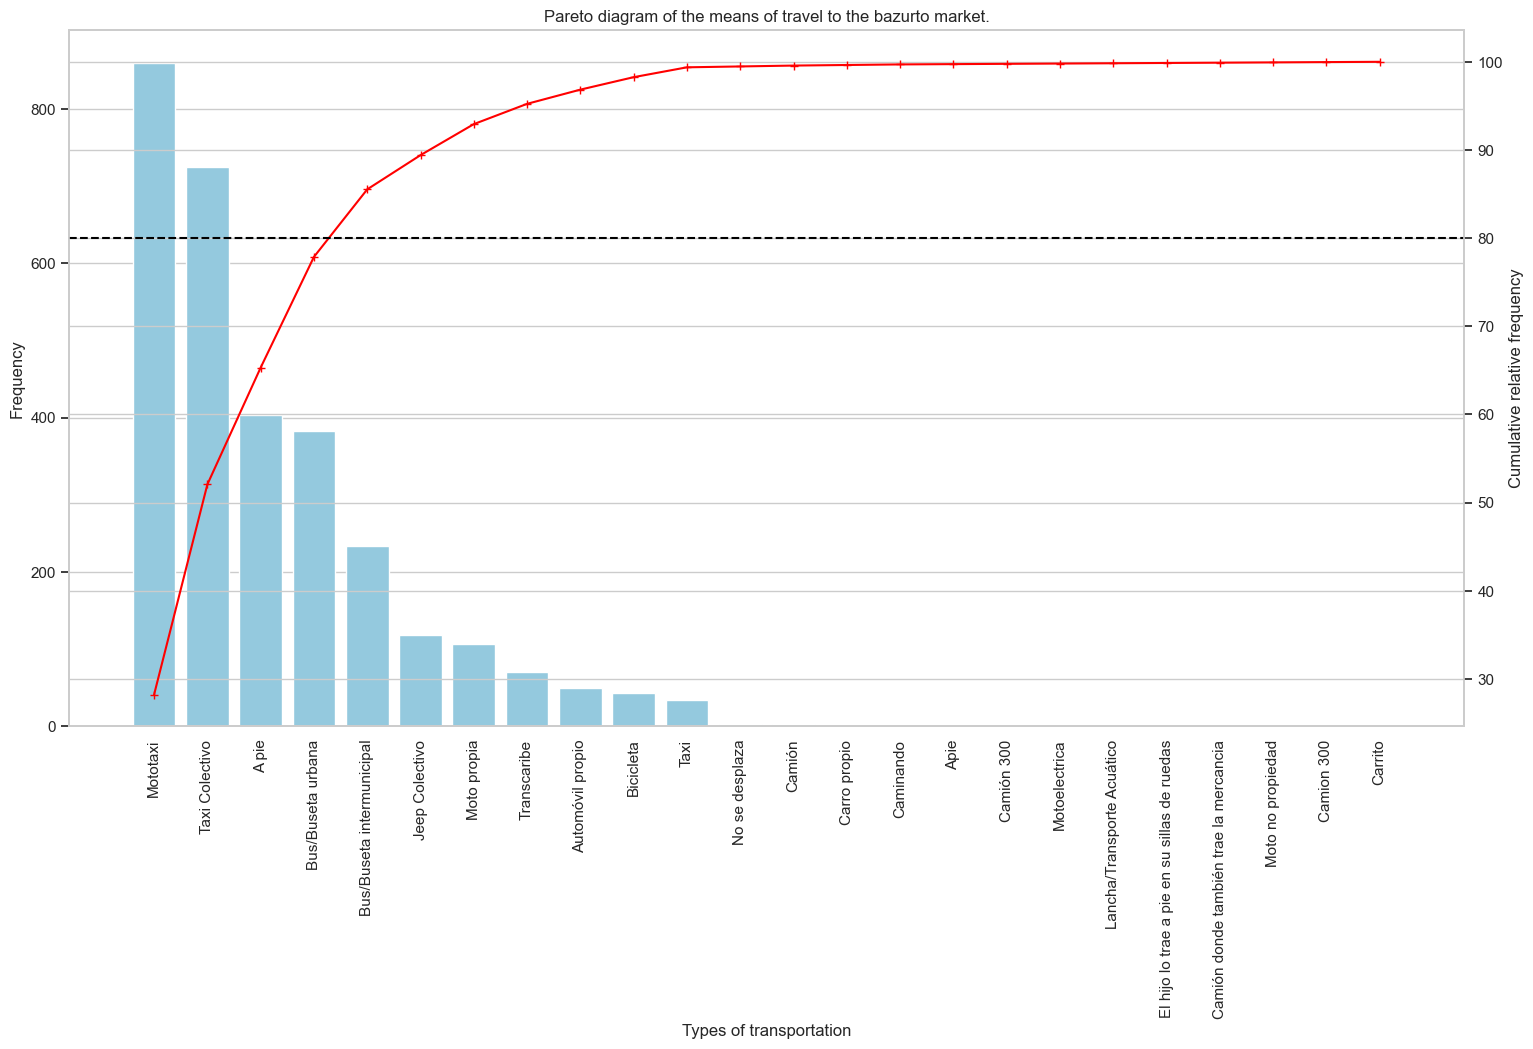

In [95]:
# Create matching graph based on the means of transportation used to get to the workplace

Transportation_count = df['Medio de transporte'].value_counts()

# Create bar chart 
plt.figure(figsize=(18,12)) 
sns.barplot(x=Transportation_count.index, y=Transportation_count.values, color='skyblue') 
plt.xticks(rotation=90) 
plt.xlabel('Types of transportation') 
plt.ylabel('Frequency')
plt.subplots_adjust(bottom=0.3)

# CUMULATIVE FREQUENCY


accumulated = Transportation_count.cumsum()
sumacum  = Transportation_count.sum()

# CUMULATIVE RELATIVE FREQUENCY
acumm = (accumulated/sumacum)*100

#Crear segundo eje
plt.twinx() 
plt.plot(Transportation_count.index, acumm, color='red', marker='+') 
plt.ylabel('Cumulative relative frequency') 
plt.axhline(y=80,color='black', linestyle='--') 
plt.title('Pareto diagram of the means of travel to the bazurto market.')

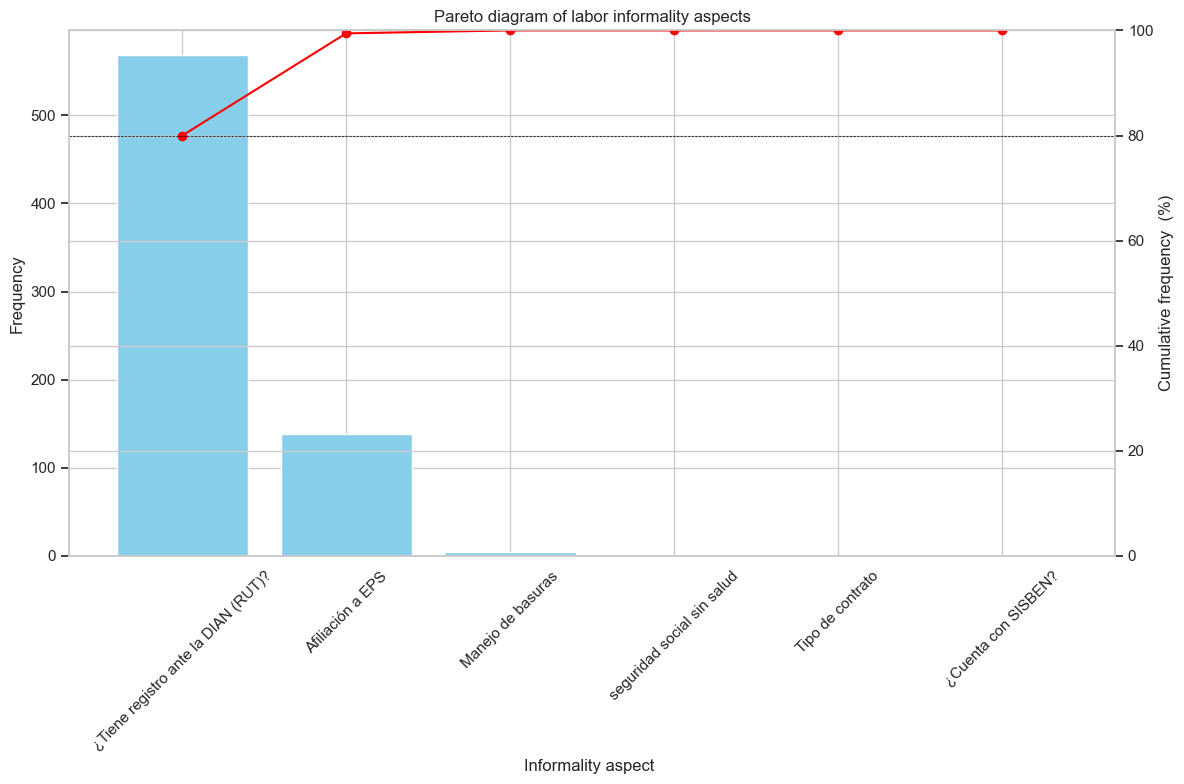

In [96]:
# Select relevant columns 
columns_of_interest = [
    "¿Tiene registro ante la DIAN (RUT)?",
    "Afiliación a EPS",
    "seguridad social sin salud",
    "Tipo de contrato",
    "Manejo de basuras",
    "¿Cuenta con SISBEN?"
]

# Calculate the frequency of informality (null or “No” values).
informalidad_counts = {}
for column in columns_of_interest:
    informalidad_counts[column] = df[column].isna().sum() + (df[column] == "No").sum()

# Convert to DataFrame and sort
informalidad_df = pd.DataFrame(list(informalidad_counts.items()), columns=["Aspecto", "Frecuencia"])
informalidad_df = informalidad_df.sort_values(by="Frecuencia", ascending=False).reset_index(drop=True)

# Calculate the cumulative frequency in percent
informalidad_df["Frecuencia acumulada (%)"] = informalidad_df["Frecuencia"].cumsum() / informalidad_df["Frecuencia"].sum() * 100

# Create the Pareto diagram
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar chart for frequency of each aspect
ax1.bar(informalidad_df["Aspecto"], informalidad_df["Frecuencia"], color="skyblue")
ax1.set_xlabel("Informality aspect ")
ax1.set_ylabel("Frequency")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title("Pareto diagram of labor informality aspects")

#  Cumulative frequency line
ax2 = ax1.twinx()
ax2.plot(informalidad_df["Aspecto"], informalidad_df["Frecuencia acumulada (%)"], color="red", marker="o", linestyle="-")
ax2.axhline(80, color="black", linestyle="--", linewidth=0.5) 
ax2.set_ylabel("Cumulative frequency  (%)")
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()

### Pair charts

<Figure size 1400x1000 with 0 Axes>

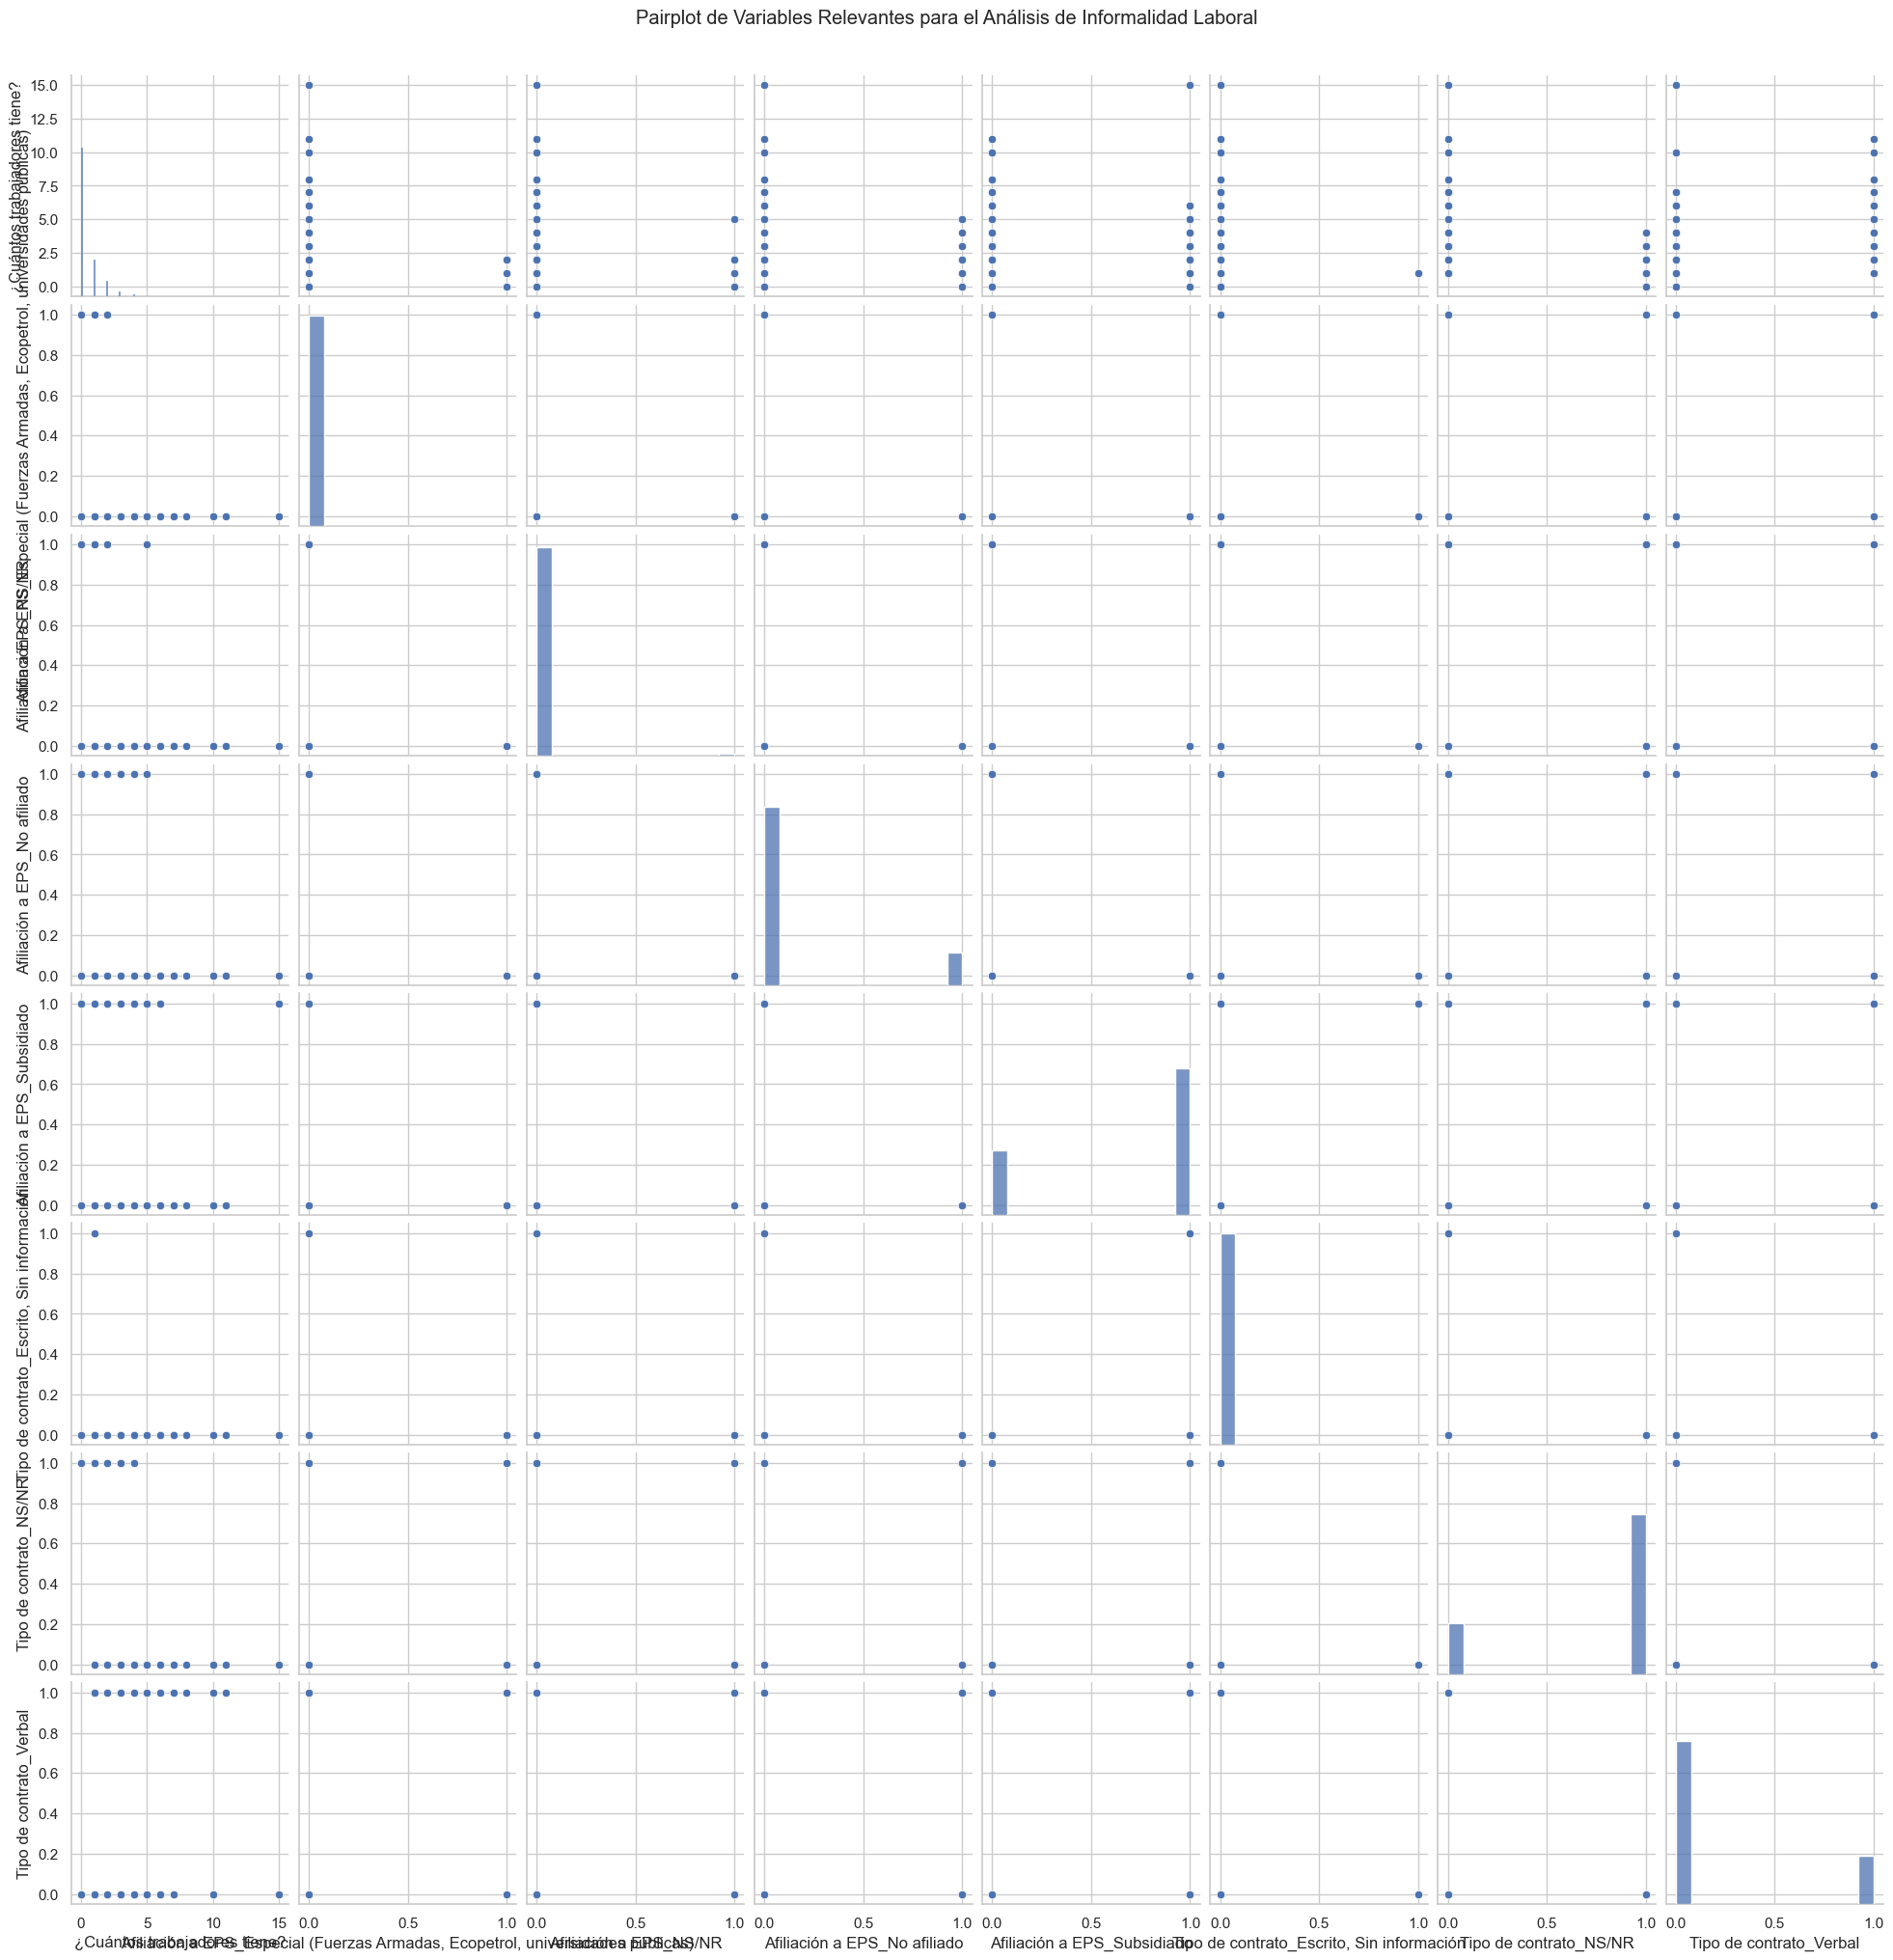

In [97]:
# List of columns relevant to the analysis
relevant_columns_pairplot = [
    "¿Cuántos trabajadores tiene?",
    "Afiliación a EPS",
    "Tipo de contrato"
]

# Filter the DataFrame to include only relevant columns
filtered_df = df[relevant_columns_pairplot]

# Encode categorical variables with one-hot encoding, dropping the first category to avoid multicollinearity
encoded_df = pd.get_dummies(filtered_df, drop_first=True)

# Plot the pairplot
plt.figure(figsize=(14, 10))
sns.pairplot(encoded_df)
plt.suptitle("Pairplot de Variables Relevantes para el Análisis de Informalidad Laboral", y=1.02)
plt.show()

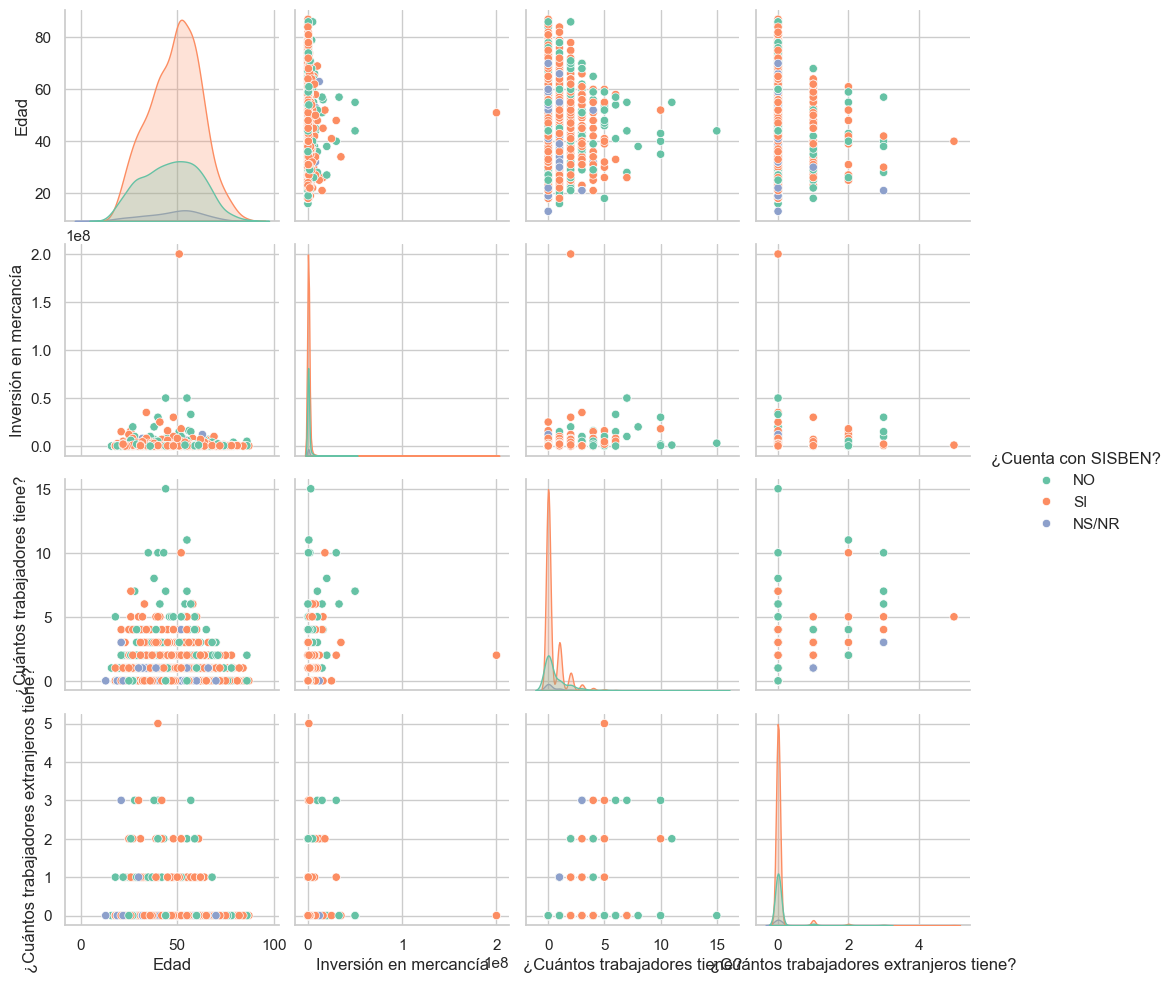

In [98]:
sns.pairplot(df, vars=['Edad','Inversión en mercancía', '¿Cuántos trabajadores tiene?', '¿Cuántos trabajadores extranjeros tiene?'], hue='¿Cuenta con SISBEN?', palette='Set2')
plt.show()

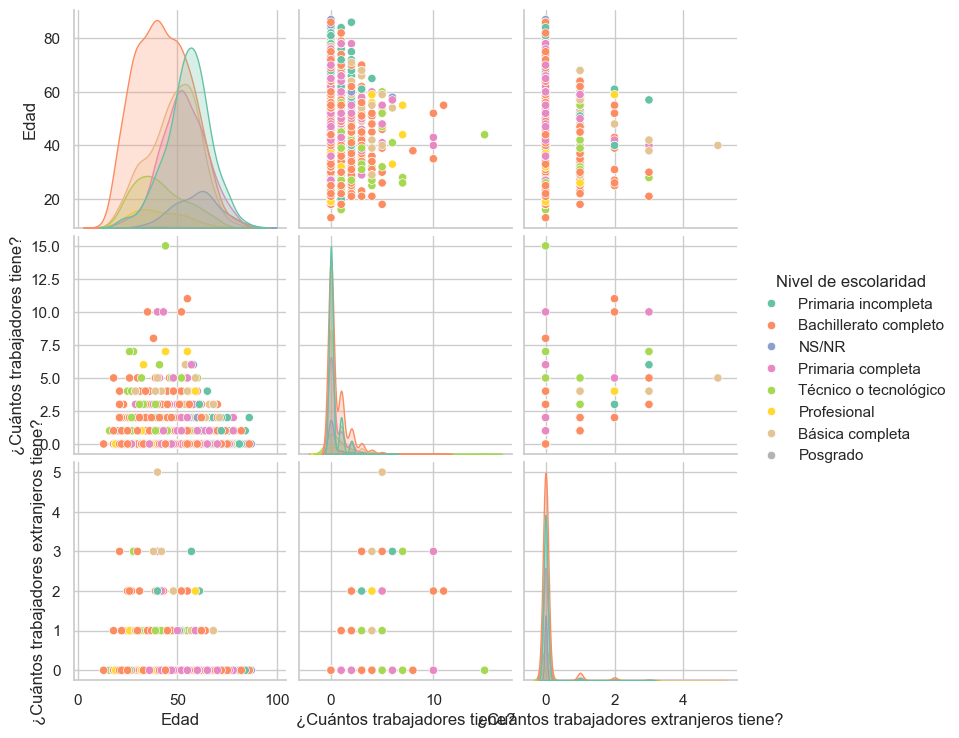

In [99]:
sns.pairplot(df, vars=['Edad','¿Cuántos trabajadores tiene?', '¿Cuántos trabajadores extranjeros tiene?'], hue='Nivel de escolaridad', palette='Set2')
plt.show()

### Catplot

   _index                   fecha  Edad     Genero               Grupo étnico  \
0       1  08/22/2021 12:00:00 AM  44.0  Masculino  Ninguno de los anteriores   
1       2  08/22/2021 12:00:00 AM  63.0   Femenino  Ninguno de los anteriores   
2       3  08/22/2021 12:00:00 AM  39.0  Masculino  Ninguno de los anteriores   
3       4  08/22/2021 12:00:00 AM  48.0  Masculino  Ninguno de los anteriores   
4       5  08/22/2021 12:00:00 AM  40.0   Femenino  Ninguno de los anteriores   

   Víctima del conflicto Tipo de discapacidad ¿Cuenta con SISBEN?  \
0                      0     Sin discapacidad                  NO   
1                      0     Sin discapacidad                  NO   
2                      0     Sin discapacidad                  SI   
3                      1     Sin discapacidad                  SI   
4                      0     Sin discapacidad                  SI   

  Hora de Apertura del Comercio Hora Cierre del Comercio  ...  \
0            16:00:00.000-05:00  

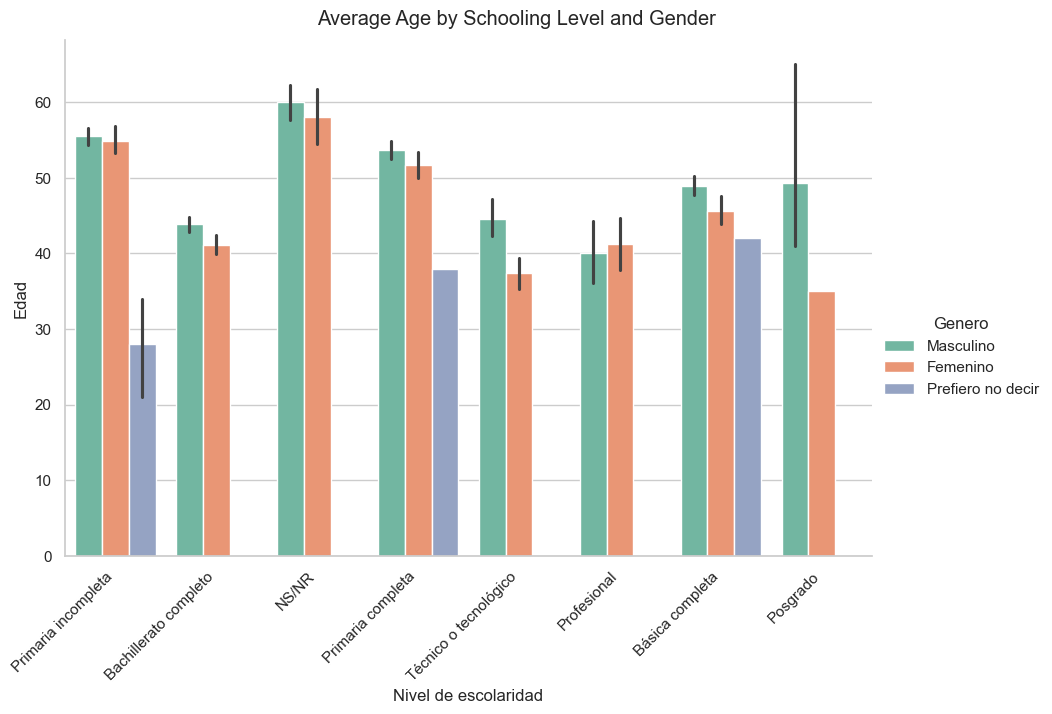

In [100]:
print(df.head())


sns.set(style="whitegrid")

#  Create a catplot of bars grouped by gender
g = sns.catplot(
    data=df, 
    x="Nivel de escolaridad", 
    y="Edad", 
    hue="Genero", 
    kind="bar", 
    height=6, 
    aspect=1.5, 
    palette="Set2",
)

# Rotate the names of the levels of schooling to make them look better
g.set_xticklabels(rotation=45, ha="right")

# General title 
g.fig.suptitle('Average Age by Schooling Level and Gender', y=1.02)

# Display the graph
plt.show()


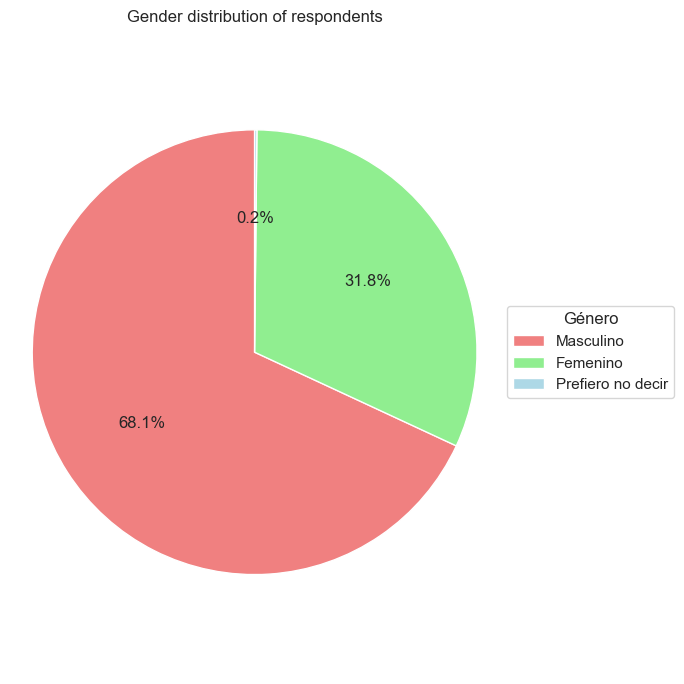

In [101]:
# Count how many respondents there are for each gender.

count_masculino = df[df['Genero'] == 'Masculino'].shape[0]
count_femenino = df[df['Genero'] == 'Femenino'].shape[0]
count_prefiero_no_decir = df[df['Genero'] == 'Prefiero no decir'].shape[0]

# Create the data for the chart
labels = ['Masculino', 'Femenino', 'Prefiero no decir']
sizes = [count_masculino, count_femenino, count_prefiero_no_decir]
colors = ['lightcoral', 'lightgreen', 'lightblue']

# Create cake graphic
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=90)

# Make sure that the graph is a circle.
plt.axis('equal')

plt.legend(wedges, labels, title="Género", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title('Gender distribution of respondents')

plt.tight_layout()
plt.show()


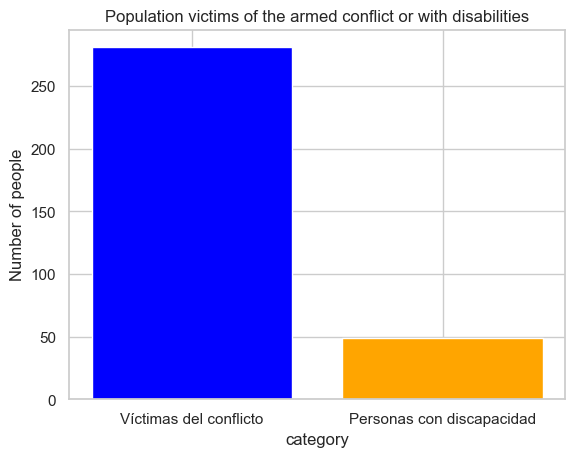

In [102]:
victimas_conflicto = df[df["Víctima del conflicto"] == 1]
personas_discapacidad = df[df["Tipo de discapacidad"] != "Sin discapacidad"]

victimas_o_discapacidad = pd.concat([victimas_conflicto, personas_discapacidad]).drop_duplicates()


data = {
    'Víctimas del conflicto': victimas_conflicto.shape[0],
    'Personas con discapacidad': personas_discapacidad.shape[0]
}

# Create a bar chart with the data
plt.bar(data.keys(), data.values(), color=['blue', 'orange'])
plt.title('Population victims of the armed conflict or with disabilities')
plt.xlabel('category')
plt.ylabel('Number of people')
plt.show()

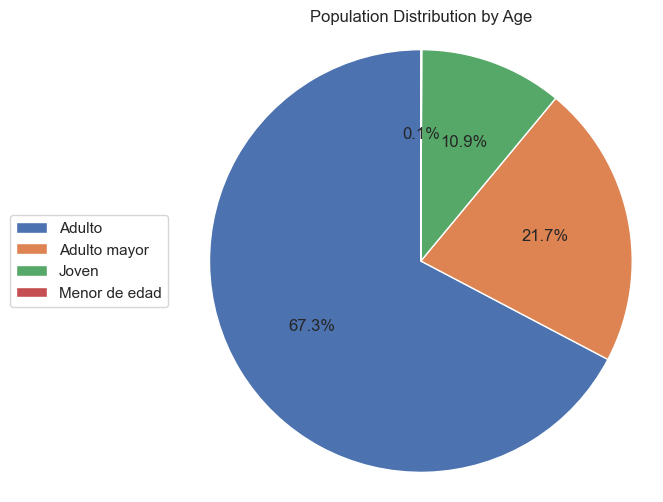

In [103]:
# Sorting by age

def clasificar_edades(row):
    if row < 18:
        return 'Menor de edad'
    
    elif 18 <= row < 30:
        return 'Joven'
    
    elif 30 <= row < 60:
        return 'Adulto'
    
    else:
        return 'Adulto mayor'
    

df['categoría_edad'] = df['Edad'].apply(clasificar_edades)

conteo_categoria = df['categoría_edad'].value_counts()

# Create a pie chart
plt.figure(figsize=(6,6))
plt.pie(conteo_categoria, labels=None, autopct='%1.1f%%', startangle=90, labeldistance=1.1)
plt.title('Population Distribution by Age')
plt.axis('equal') 
plt.legend(conteo_categoria.index, loc='center left', bbox_to_anchor=(-0.4, 0.5))

plt.show()

### Violinplot

C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_19924\1336766046.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Tipo de contrato', y='Inversión en mercancía', data=df, palette='Set2')


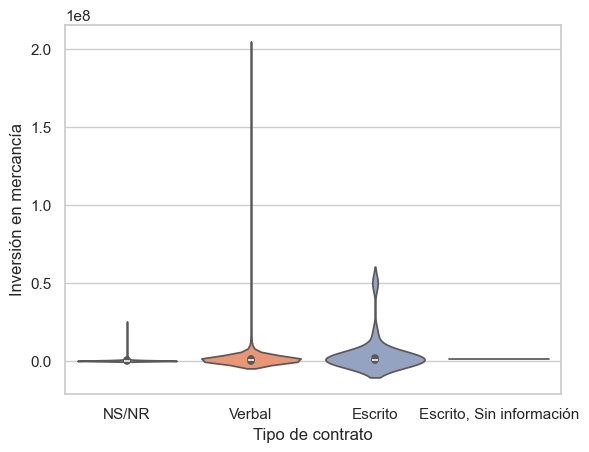

In [104]:
sns.violinplot(x='Tipo de contrato', y='Inversión en mercancía', data=df, palette='Set2')
plt.show()

### Poitplot

C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_19924\2807967190.py:3: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(


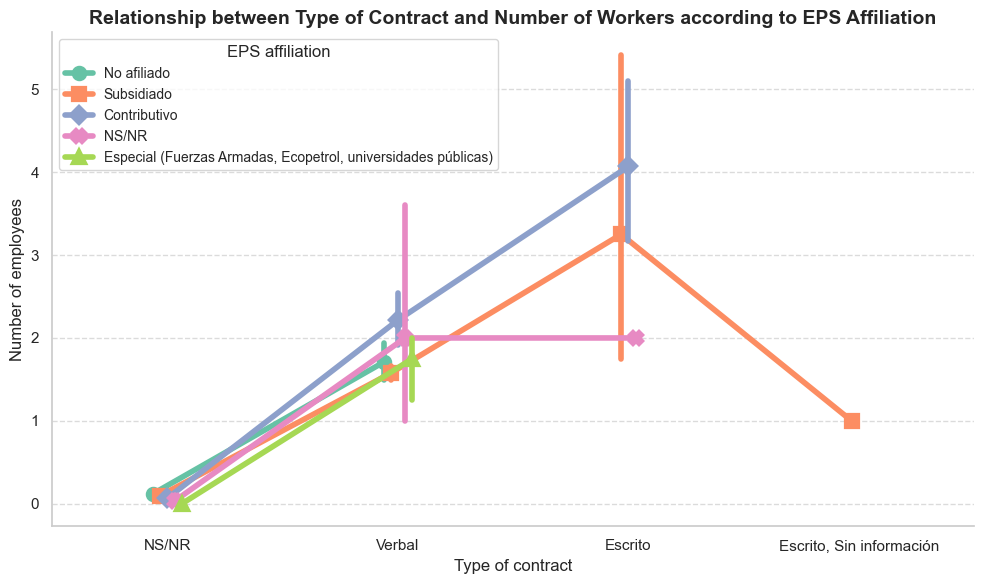

In [105]:

plt.figure(figsize=(10, 6))

sns.pointplot(
    x='Tipo de contrato',
    y='¿Cuántos trabajadores tiene?',
    hue='Afiliación a EPS',
    data=df,
    palette='Set2',
    markers=["o", "s", "D", "X", "^"],
    scale=1.5,
    dodge=True
)


plt.title('Relationship between Type of Contract and Number of Workers according to EPS Affiliation', fontsize=14, weight='bold')
plt.xlabel('Type of contract', fontsize=12)
plt.ylabel('Number of employees', fontsize=12)


plt.legend(title='EPS affiliation', title_fontsize=12, fontsize=10, loc='upper left')


sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Analysis of goods receipt hours

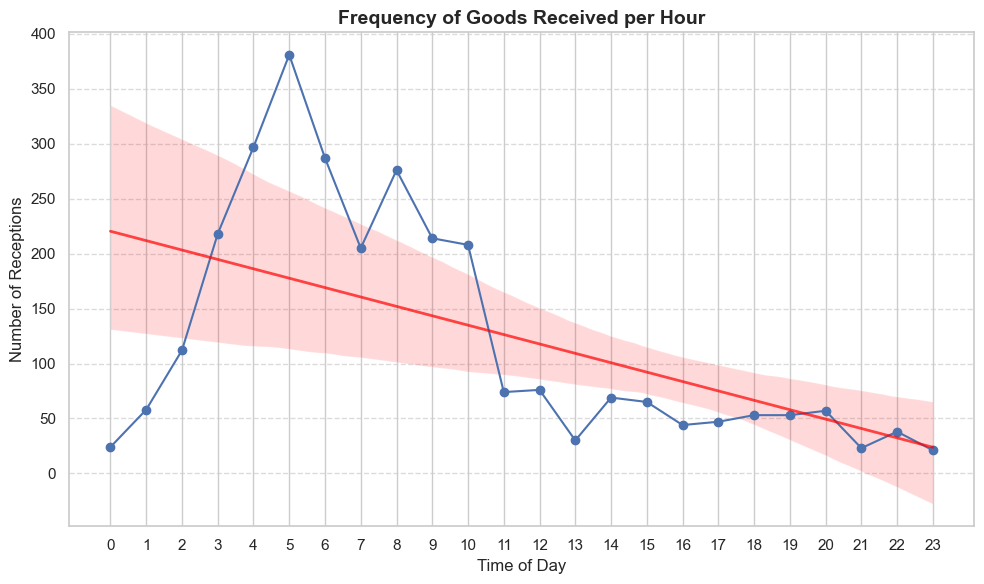

In [106]:

# Asegurarse de que la columna de la hora de recepción esté en formato adecuado
df['Hora de recepción de mercancía'] = pd.to_datetime(df['Hora de recepción de mercancía'], format='%H:%M:%S.%f%z', errors='coerce')

# Extraer solo la hora de la columna de la hora de recepción
df['Hora de recepción de mercancía'] = df['Hora de recepción de mercancía'].dt.hour

# Contar la frecuencia de recepciones por hora
recepcion_por_hora = df['Hora de recepción de mercancía'].value_counts().sort_index()

# Crear la figura para la gráfica
plt.figure(figsize=(10, 6))

# Graficar la frecuencia de recepciones por hora
plt.plot(recepcion_por_hora.index, recepcion_por_hora.values, marker='o', linestyle='-', color='b')

# Agregar la línea de regresión lineal con seaborn
sns.regplot(
    x=recepcion_por_hora.index, 
    y=recepcion_por_hora.values, 
    scatter=False,  # Evitar que se muestren los puntos de dispersión nuevamente
    line_kws={"color": "red", "alpha": 0.7, "lw": 2}  # Estilo de la línea de regresión
)

# Títulos y etiquetas
plt.title('Frequency of Goods Received per Hour', fontsize=14, weight='bold')
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Number of Receptions', fontsize=12)

# Ajustar los ticks del eje X para mostrar las horas de 0 a 23
plt.xticks(range(0, 24))

# Hacer la rejilla solo en el eje Y para mayor claridad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajuste final y mostrar la gráfica
plt.tight_layout()
plt.show()


### Linear regression

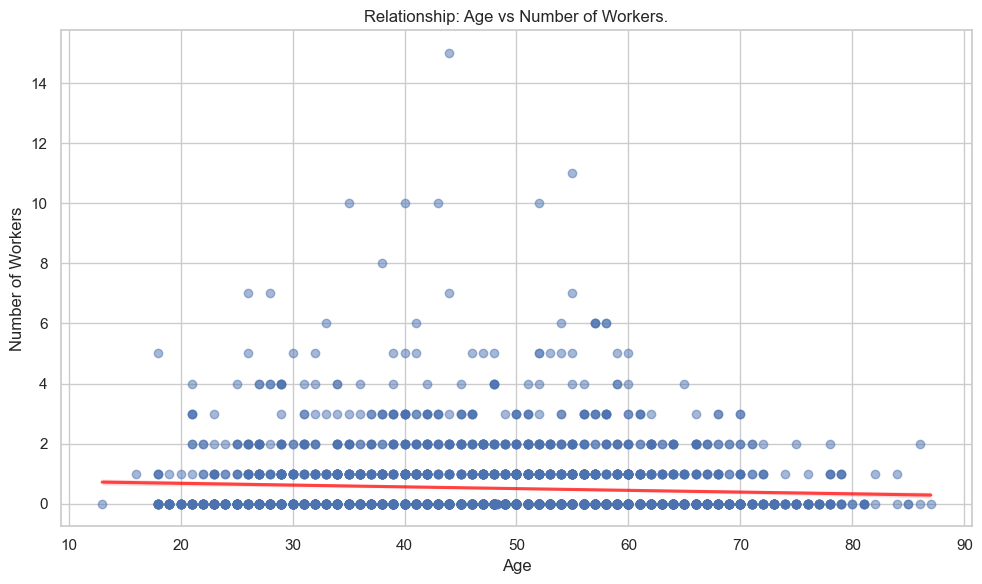

C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_19924\259803413.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Hora de Apertura del Comercio"] = pd.to_datetime(df["Hora de Apertura del Comercio"], errors="coerce").dt.hour


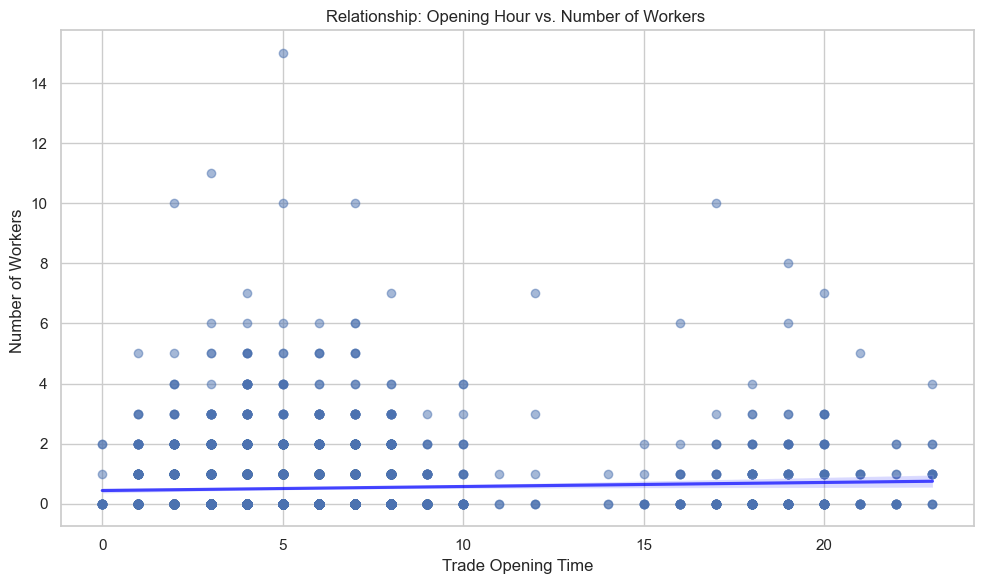

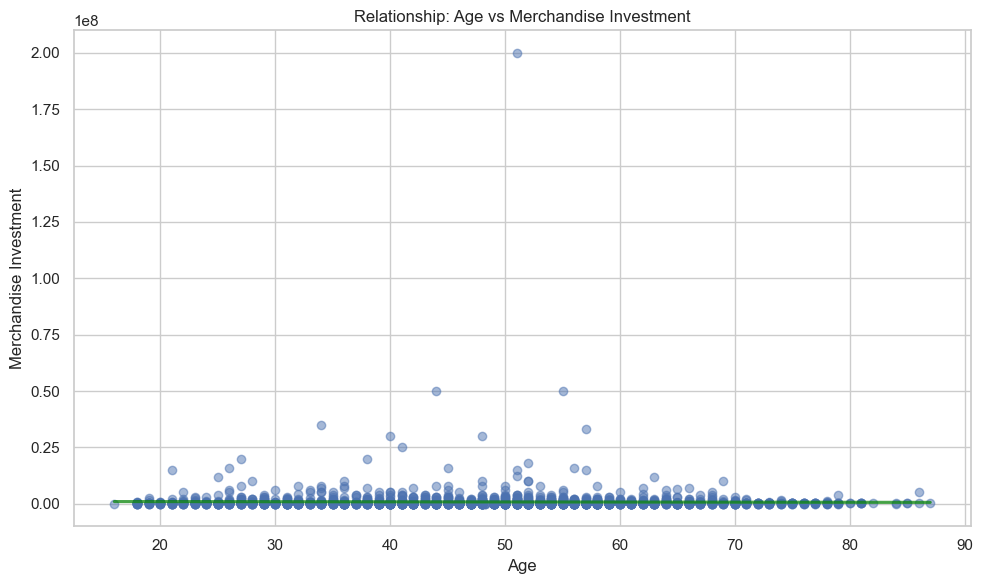

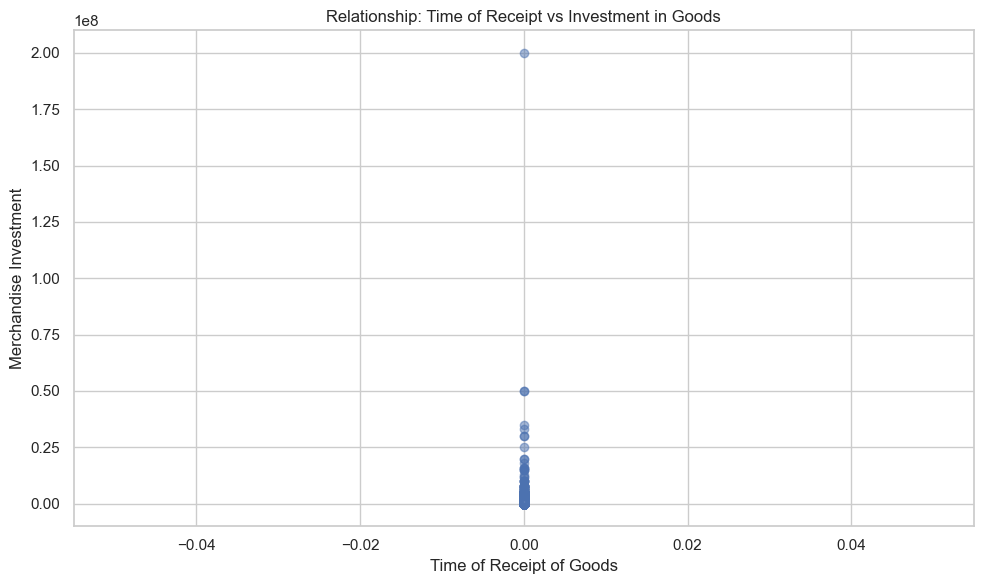

In [107]:
# --------------------------------------------------
# Gráfica 1: Edad vs Cantidad de Trabajadores (Regresión Lineal)
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df, 
    x="Edad", 
    y="¿Cuántos trabajadores tiene?", 
    line_kws={"color": "red", "alpha": 0.7}, 
    scatter_kws={"alpha": 0.5}
)
plt.title("Relationship: Age vs Number of Workers.")
plt.xlabel("Age")
plt.ylabel("Number of Workers")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Gráfica 2: Hora de Apertura vs Cantidad de Trabajadores (Regresión Lineal)
df["¿Cuántos trabajadores tiene?"] = pd.to_numeric(df["¿Cuántos trabajadores tiene?"], errors="coerce")

# Convierte las horas a un formato de 24 horas (flotante o datetime)
df["Hora de Apertura del Comercio"] = pd.to_datetime(df["Hora de Apertura del Comercio"], errors="coerce").dt.hour
df["Hora de recepción de mercancía"] = pd.to_datetime(df["Hora de recepción de mercancía"], errors="coerce").dt.hour

# Elimina filas con valores no numéricos después de la conversión
df = df.dropna(subset=["¿Cuántos trabajadores tiene?", "Hora de Apertura del Comercio", "Hora de recepción de mercancía"])

# Ahora, genera las gráficas con las columnas corregidas
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df, 
    x="Hora de Apertura del Comercio", 
    y="¿Cuántos trabajadores tiene?", 
    line_kws={"color": "blue", "alpha": 0.7}, 
    scatter_kws={"alpha": 0.5}
)
plt.title("Relationship: Opening Hour vs. Number of Workers ")
plt.xlabel("Trade Opening Time")
plt.ylabel("Number of Workers ")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Gráfica 3: Inversión en Mercancía vs Edad (Regresión Lineal)
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df, 
    x="Edad", 
    y="Inversión en mercancía", 
    line_kws={"color": "green", "alpha": 0.7}, 
    scatter_kws={"alpha": 0.5}
)
plt.title("Relationship: Age vs Merchandise Investment")
plt.xlabel("Age")
plt.ylabel("Merchandise Investment")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Gráfica 4: Hora de Recepción de Mercancía vs Inversión (Regresión Lineal)
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df, 
    x="Hora de recepción de mercancía", 
    y="Inversión en mercancía", 
    line_kws={"color": "purple", "alpha": 0.7}, 
    scatter_kws={"alpha": 0.5}
)
plt.title("Relationship: Time of Receipt vs Investment in Goods")
plt.xlabel("Time of Receipt of Goods")
plt.ylabel("Merchandise Investment")
plt.tight_layout()
plt.show()
